In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/LICENSE
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/.gitignore
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/main.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/README.md
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/results.txt
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/solver.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/attn.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/AnomalyTransformer.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/__init__.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/model/embed.py
/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main/utils/utils.py
/kag

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2025-05-19 22:44:50.393232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747694690.638218      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747694690.705701      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')
print("TensorFlow version:", tf.__version__)
print("Environment setup complete.")

TensorFlow version: 2.18.0
Environment setup complete.


In [4]:
data_path = "/kaggle/input/nasa-cmaps/CMaps/"
# If the above path doesn't work, use the alternative:
if not os.path.exists(data_path):
    data_path = "/kaggle/input/nasa-cmaps/cmaps/CMaps/"

print(f"Using data path: {data_path}")

Using data path: /kaggle/input/nasa-cmaps/CMaps/


In [5]:
def load_cmapss_data(data_path, dataset_num=1):
    """
    Load the NASA CMAPSS dataset.
    
    Args:
        data_path: Directory containing CMAPSS data files
        dataset_num: Dataset number (1-4)
        
    Returns:
        train_df: Training dataframe
        test_df: Testing dataframe
        RUL_df: Remaining useful life ground truth
    """
    # Define column names for the data
    columns = ['unit', 'cycle', 'op1', 'op2', 'op3'] + \
              [f'sensor{i}' for i in range(1, 22)]
    
    # Load training data
    train_file = f"train_FD00{dataset_num}.txt"
    train_path = os.path.join(data_path, train_file)
    train_df = pd.read_csv(train_path, sep=' ', header=None, names=columns)
    train_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    test_file = f"test_FD00{dataset_num}.txt"
    test_path = os.path.join(data_path, test_file)
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=columns)
    test_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    
    # Load RUL ground truth
    rul_file = f"RUL_FD00{dataset_num}.txt"
    rul_path = os.path.join(data_path, rul_file)
    RUL_df = pd.read_csv(rul_path, sep=' ', header=None)
    RUL_df.dropna(axis=1, inplace=True)  # Drop NaN columns
    RUL_df.columns = ['RUL']
    
    print(f"Loaded dataset {dataset_num}:")
    print(f"- Training set: {train_df.shape}")
    print(f"- Test set: {test_df.shape}")
    print(f"- RUL values: {RUL_df.shape}")
    
    return train_df, test_df, RUL_df

In [6]:
train_df, test_df, RUL_df = load_cmapss_data(data_path, dataset_num=1)

Loaded dataset 1:
- Training set: (20631, 24)
- Test set: (13096, 24)
- RUL values: (100, 1)


In [7]:
train_df

unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  \
1   1   -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62   
    2    0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62   
    3   -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62   
    4    0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62   
    5   -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62   
...         ...     ...    ...     ...     ...      ...      ...      ...   
100 196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63    14.62   
    197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58    14.62   
    198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18    14.62   
    199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53    14.62   
    200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14    14.62   

         sensor4  sensor5  ...  sensor10  sensor11  sensor12  sensor13  \
1   1      21.61   554.36  ...    521.66   2388.02   8138.62    8.4195   
    2      21.61   553.75  ...    522.28   2388.07   8131.49    8.4318   
    3      21.61   554.26  ...    522.42   2388.03   8133.23    8.4178   
    4      21.61   554.45  ...    522.86   2388.08   8133.83    8.3682   
    5      21.61   554.00  ...    522.19   2388.04   8133.80    8.4294   
...          ...      ...  ...       ...       ...       ...       ...   
100 196    21.61   551.43  ...    519.49   2388.26   8137.60    8.4956   
    197    21.61   550.86  ...    519.68   2388.22   8136.50    8.5139   
    198    21.61   550.94  ...    520.01   2388.24   8141.05    8.5646   
    199    21.61   550.68  ...    519.67   2388.23   8139.29    8.5389   
    200    21.61   550.79  ...    519.30   2388.26   8137.33    8.5036   

         sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  
1   1        0.03       392      2388     100.0     39.06   23.4190  
    2        0.03       392      2388     100.0     39.00   23.4236  
    3        0.03       390      2388     100.0     38.95   23.3442  
    4        0.03       392      2388     100.0     38.88   23.3739  
    5        0.03       393      2388     100.0     38.90   23.4044  
...           ...       ...       ...       ...       ...       ...  
100 196      0.03       397      2388     100.0     38.49   22.9735  
    197      0.03       395      2388     100.0     38.30   23.1594  
    198      0.03       398      2388     100.0     38.44   22.9333  
    199      0.03       395      2388     100.0     38.29   23.0640  
    200      0.03       396      2388     100.0     38.37   23.0522  

[20631 rows x 24 columns]


Training data sample:
       unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  \
1 1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62   
  2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62   
  3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62   
  4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62   
  5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62   

     sensor4  sensor5  ...  sensor10  sensor11  sensor12  sensor13  sensor14  \
1 1    21.61   554.36  ...    521.66   2388.02   8138.62    8.4195      0.03   
  2    21.61   553.75  ...    522.28   2388.07   8131.49    8.4318      0.03   
  3    21.61   554.26  ...    522.42   2388.03   8133.23    8.4178      0.03   
  4    21.61   554.45  ...    522.86   2388.08   8133.83    8.3682      0.03   
  5    21.61   554.00  ...    522.19   2388.04   8133.80    8.4294      0.03   

     sensor15  sensor16  sensor17  sensor18  sensor19  
1

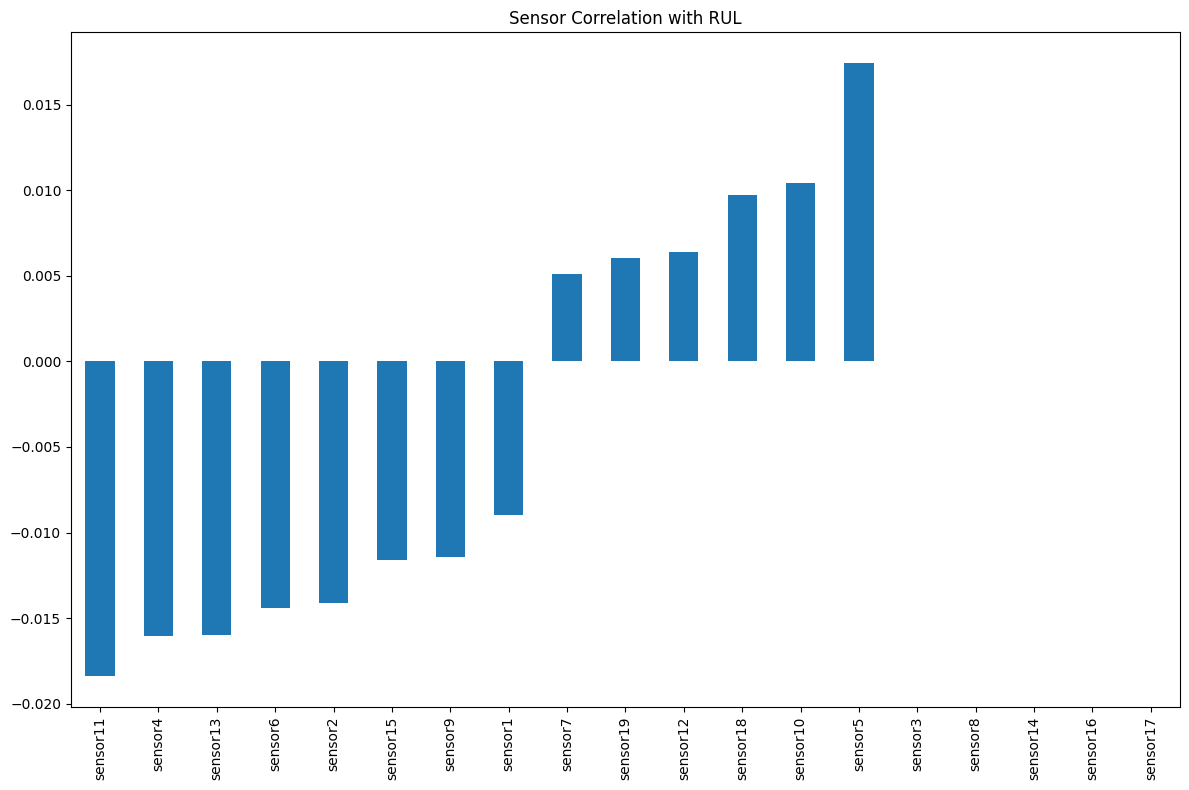


Selected 0 important sensors: []


In [8]:
# Step 4: Explore and preprocess data
# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())

# Add RUL to training data
# Get the maximum cycle for each unit
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']

# Merge with the training data
train_df = train_df.merge(max_cycles, on=['unit'], how='left')

# Calculate RUL (Remaining Useful Life)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Calculate correlation with RUL
correlation = train_df.corr()['RUL'].sort_values()
print("\nCorrelation with RUL:")
print(correlation)

# Visualize correlation with RUL
plt.figure(figsize=(12, 8))
sensor_cols = [col for col in train_df.columns if col.startswith('sensor')]
correlation[sensor_cols].sort_values().plot(kind='bar')
plt.title('Sensor Correlation with RUL')
plt.tight_layout()
plt.show()

# Select important sensors (correlation > 0.1 or < -0.1)
important_sensors = [col for col in sensor_cols if abs(correlation[col]) > 0.1]
print(f"\nSelected {len(important_sensors)} important sensors: {important_sensors}")

# Select features for model training
selected_features = ['cycle'] + important_sensors


Training data sample:
     unit   cycle    op1     op2     op3  sensor1  sensor2  sensor3  sensor4  \
0 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60    14.62    21.61   
1  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14    14.62    21.61   
2 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20    14.62    21.61   
3  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87    14.62    21.61   
4 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22    14.62    21.61   

   sensor5  ...  sensor11  sensor12  sensor13  sensor14  sensor15  sensor16  \
0   554.36  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1   553.75  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2   554.26  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3   554.45  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4   554.00  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor17  sensor18

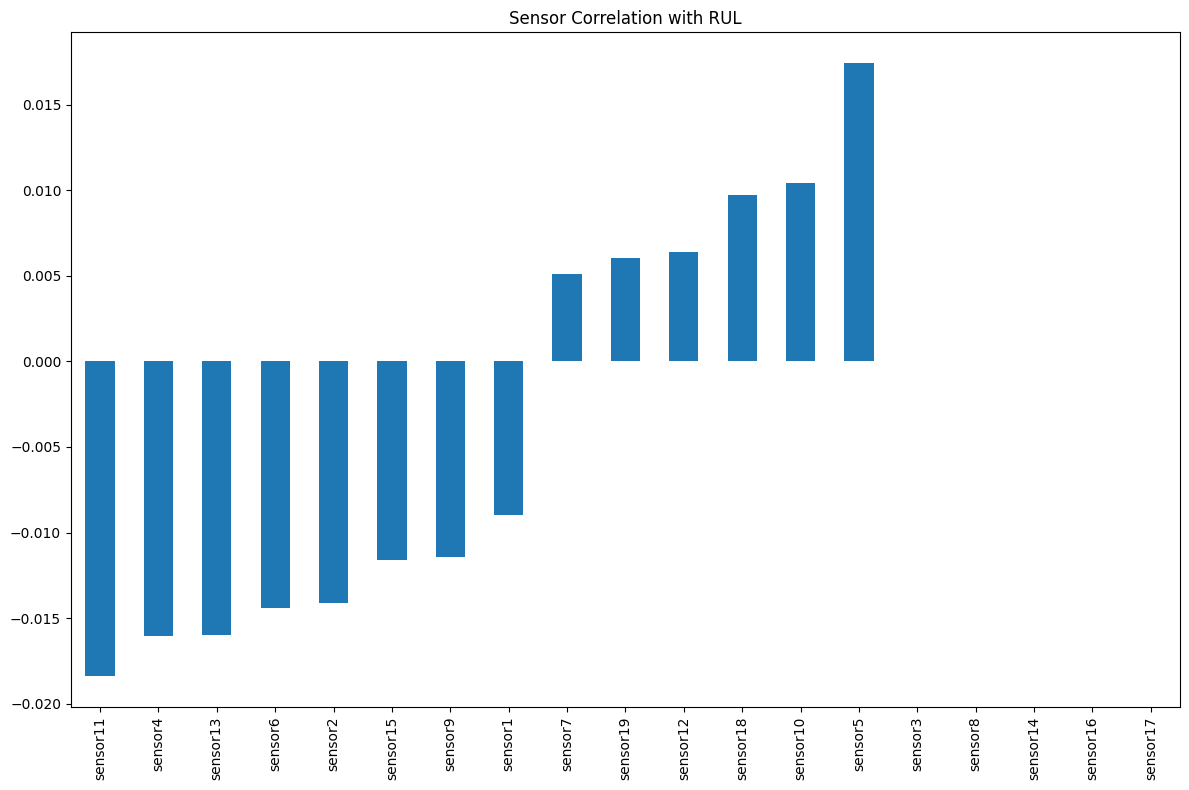


Selected 9 important sensors: ['sensor2', 'sensor4', 'sensor5', 'sensor6', 'sensor9', 'sensor10', 'sensor11', 'sensor13', 'sensor15']
Features used for model training: ['cycle', 'sensor2', 'sensor4', 'sensor5', 'sensor6', 'sensor9', 'sensor10', 'sensor11', 'sensor13', 'sensor15']


In [9]:
# Step 4: Explore and preprocess data
# Display sample data
print("\nTraining data sample:")
print(train_df.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum().sum())

# Add RUL to training data
# Get the maximum cycle for each unit
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']

# Merge with the training data
train_df = train_df.merge(max_cycles, on=['unit'], how='left')

# Calculate RUL (Remaining Useful Life)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Calculate correlation with RUL
correlation = train_df.corr()['RUL'].sort_values()
print("\nCorrelation with RUL:")
print(correlation)

# Visualize correlation with RUL
plt.figure(figsize=(12, 8))
sensor_cols = [col for col in train_df.columns if col.startswith('sensor')]
correlation[sensor_cols].sort_values().plot(kind='bar')
plt.title('Sensor Correlation with RUL')
plt.tight_layout()
plt.show()

# Select important sensors (correlation > 0.1 or < -0.1)
important_sensors = [col for col in sensor_cols if abs(correlation[col]) > 0.01]
print(f"\nSelected {len(important_sensors)} important sensors: {important_sensors}")

# This is the fix: Only include cycle and the important sensors
selected_features = ['cycle'] + important_sensors
print(f"Features used for model training: {selected_features}")

# Step 5: Normalize the data (with the fix applied)
scaler = MinMaxScaler()

# Only normalize the selected features (not all features)
train_normalized = pd.DataFrame(
    scaler.fit_transform(train_df[selected_features]),
    columns=selected_features
)

# Also normalize test data - only the selected features
test_normalized = pd.DataFrame(
    scaler.transform(test_df[selected_features]),
    columns=selected_features
)

In [10]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define sensor columns (excluding those with NaN correlation)
valid_sensor_cols = correlation[~correlation.isna()].index.tolist()
valid_sensor_cols = [col for col in valid_sensor_cols if col.startswith('sensor')]

# Prepare data
X = train_df[valid_sensor_cols]
y = train_df['RUL']

# Fit a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=valid_sensor_cols)
important_sensors = importances.sort_values(ascending=False).head(10).index.tolist()

# Final selected features
selected_features = ['cycle'] + important_sensors
print(f"Top 10 important sensors based on Random Forest: {important_sensors}")
print(f"Features used for model training: {selected_features}")


Top 10 important sensors based on Random Forest: ['sensor1', 'sensor19', 'sensor13', 'sensor2', 'sensor12', 'sensor5', 'sensor7', 'sensor10', 'sensor18', 'sensor9']
Features used for model training: ['cycle', 'sensor1', 'sensor19', 'sensor13', 'sensor2', 'sensor12', 'sensor5', 'sensor7', 'sensor10', 'sensor18', 'sensor9']


In [11]:
scaler = MinMaxScaler()
train_normalized = pd.DataFrame(
    scaler.fit_transform(train_df[selected_features]),
    columns=selected_features
)

# Also normalize test data
test_normalized = pd.DataFrame(
    scaler.transform(test_df[selected_features]),
    columns=selected_features
)

# Save the unit information for reference
train_units = train_df['unit'].values
test_units = test_df['unit'].values

In [12]:
def create_sequences(data, units, sequence_length=50, step=1):
    """
    Create sequences for time series analysis.
    
    Args:
        data: Normalized data
        units: Unit IDs for each row
        sequence_length: Length of each sequence
        step: Step size for creating sequences
        
    Returns:
        X: Input sequences
        unit_indices: Unit IDs for each sequence
    """
    X = []
    unit_indices = []
    
    # Get unique units
    unique_units = np.unique(units)
    
    for unit in unique_units:
        # Get data for this unit
        unit_data = data[units == unit].values

        for i in range(0, len(unit_data) - sequence_length + 1, step):
            X.append(unit_data[i:i+sequence_length])
            unit_indices.append(unit)
    
    return np.array(X), np.array(unit_indices)


# Create sequences
sequence_length = 50  # You can adjust this
step_size = 10  # You can adjust this

X_train, train_unit_indices = create_sequences(
    train_normalized, 
    train_units,
    sequence_length=sequence_length,
    step=step_size
)

X_test, test_unit_indices = create_sequences(
    test_normalized, 
    test_units,
    sequence_length=sequence_length,
    step=step_size
)
print("\nSequence shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

# Step 7: Split training data into train and validation sets
X_train_split, X_val, train_units_split, val_units = train_test_split(
    X_train, train_unit_indices, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")


Sequence shapes:
X_train: (1583, 50, 11)
X_test: (859, 50, 11)
Training set: (1266, 50, 11)
Validation set: (317, 50, 11)


In [13]:
def build_lstm_autoencoder(input_shape, encoding_dim=32):
    """
    Build an LSTM Autoencoder for anomaly detection.
    
    Args:
        input_shape: Shape of input data (sequence_length, features)
        encoding_dim: Dimension of the encoding layer
        
    Returns:
        model: Compiled LSTM Autoencoder model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(inputs)
    encoded = Dropout(0.2)(encoded)
    encoded = Bidirectional(LSTM(32, activation='relu', return_sequences=False))(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Bottleneck
    bottleneck = Dense(encoding_dim, activation='relu')(encoded)

    decoded = RepeatVector(input_shape[0])(bottleneck)
    decoded = Bidirectional(LSTM(32, activation='relu', return_sequences=True))(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(decoded)
    decoded = Dropout(0.2)(decoded)
    
    # Output layer
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(optimizer='adam', loss='mse')
    
    return model
    
input_shape = X_train_split.shape[1:]

# Build model
model_lstm = build_lstm_autoencoder(input_shape)

# Print model summary
model_lstm.summary()

I0000 00:00:1747694732.947876      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747694732.948577      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 128)             │          38,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 64)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 50, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 11)              │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,315 (649.67 KB)

 Trainable params: 166,315 (649.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1747694774.022304      94 service.cc:148] XLA service 0x44842a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747694774.022895      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747694774.022916      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747694775.977780      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/40 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2371  

I0000 00:00:1747694784.906353      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - loss: 0.1476 - val_loss: 0.0306
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0358 - val_loss: 0.0282
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0309 - val_loss: 0.0262
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0278 - val_loss: 0.0243
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0265 - val_loss: 0.0241
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0259 - val_loss: 0.0231
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0254 - val_loss: 0.0232
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0252 - val_loss: 0.0229
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0250 - val_loss: 0.0228
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0247 - val_loss: 0.0228
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0246 - val_loss: 0.0229
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0246 - val

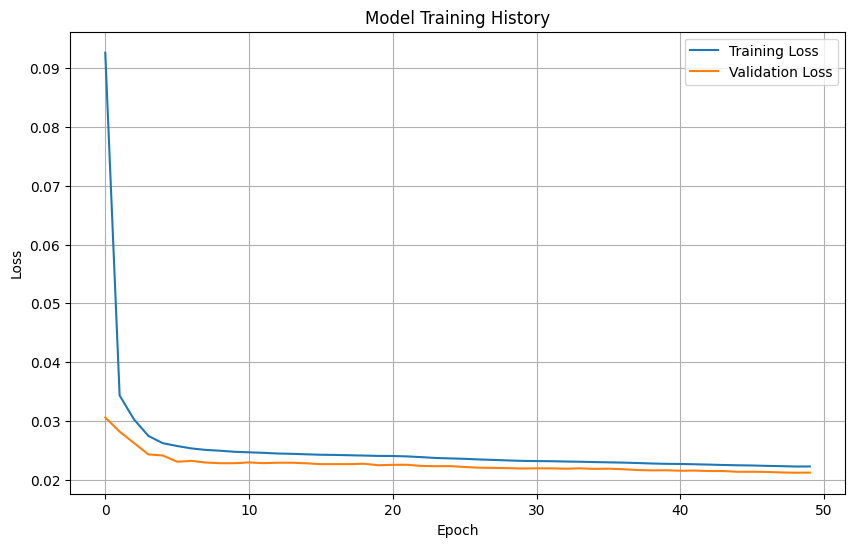

In [14]:
# Step 9: Train the model
# Set callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/lstm_autoencoder.keras',  # ✅ Correct extension
    monitor='val_loss',
    save_best_only=True
)


# Train model
history = model_lstm.fit(
    X_train_split, X_train_split,  # Autoencoder reconstructs its input
    epochs=50,  # You can reduce this for faster training in Kaggle
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Step 10: Detect anomalies in test data
# Get reconstructions
reconstructions = model_lstm.predict(X_test)

# Calculate reconstruction error (MSE) for each sequence
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=(1, 2))

# Calculate threshold (using 95th percentile of training errors)
# First, get reconstruction errors on training data
train_reconstructions = model_lstm.predict(X_train_split)
train_errors = np.mean(np.square(X_train_split - train_reconstructions), axis=(1, 2))
threshold = np.percentile(train_errors, 95)

print(f"Anomaly threshold: {threshold:.6f}")

# Detect anomalies
anomalies = reconstruction_errors > threshold
max_error = np.max(reconstruction_errors)
severity_scores = reconstruction_errors / max_error

print(f"Detected {sum(anomalies)} anomalies out of {len(anomalies)} test sequences")

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Anomaly threshold: 0.026510
Detected 0 anomalies out of 859 test sequences


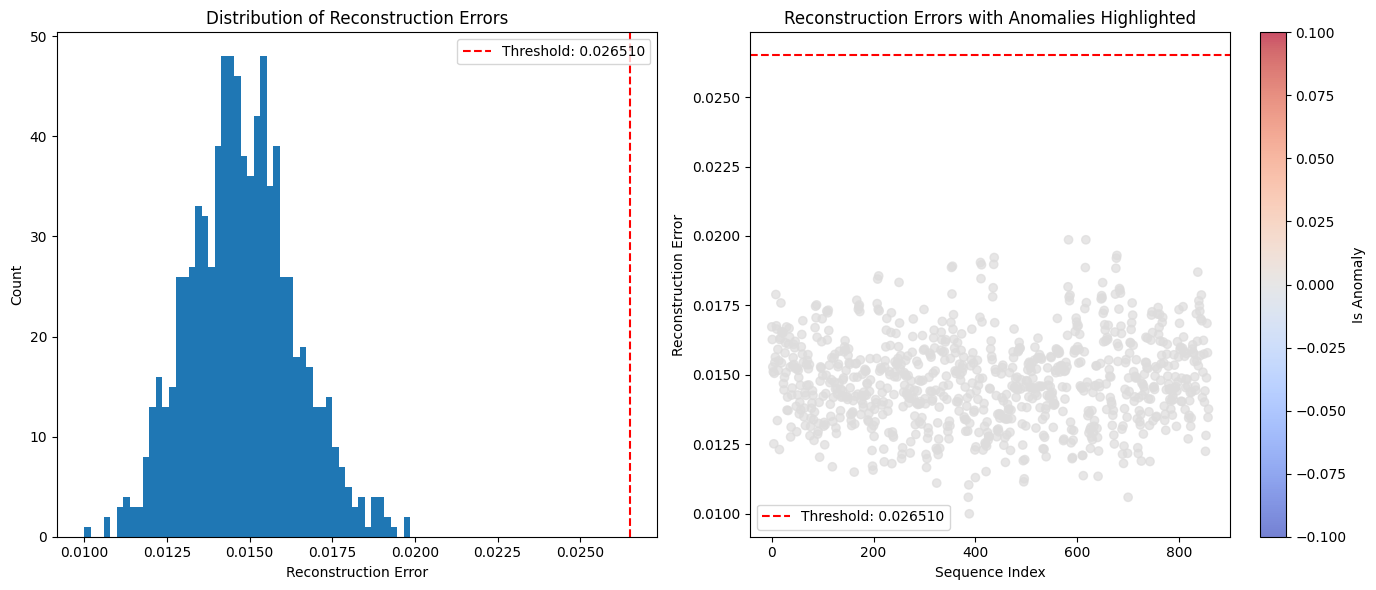

In [16]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, 
           c=anomalies, cmap='coolwarm', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors with Anomalies Highlighted')
plt.colorbar(label='Is Anomaly')
plt.legend()

plt.tight_layout()
plt.show()

Adaptive thresholding detected 28 anomalies


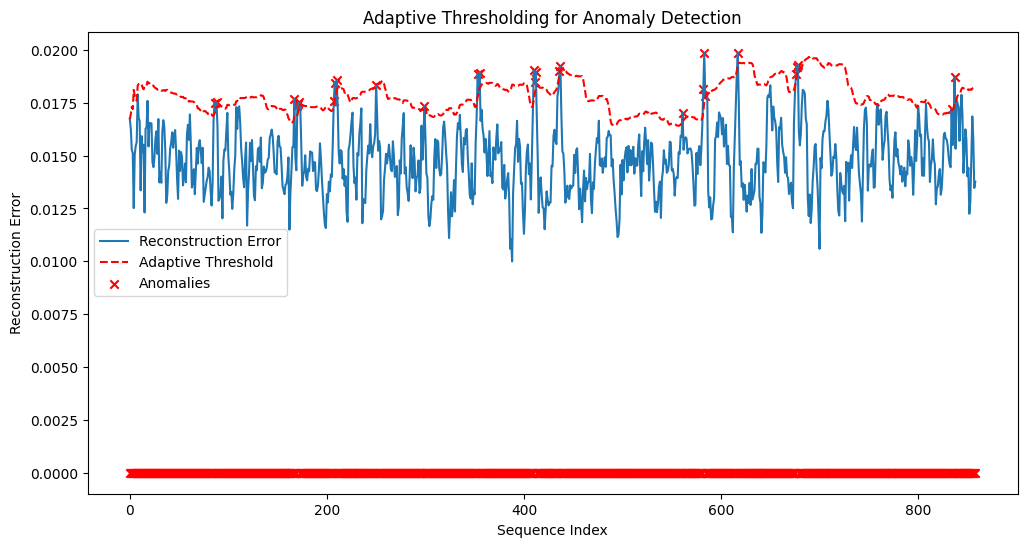

In [17]:
def adaptive_thresholding(errors, window_size=10):
    """
    Apply adaptive thresholding to reconstruction errors.
    
    Args:
        errors: Reconstruction errors
        window_size: Size of the sliding window
        
    Returns:
        thresholds: Threshold values for each point
        anomalies: Boolean array indicating anomalies
    """
    thresholds = []
    anomalies = []
    
    for i in range(len(errors)):
        # Get window of errors
        start = max(0, i - window_size)
        window_errors = errors[start:i+1]
        
        # Calculate adaptive threshold (mean + 2*std)
        window_threshold = window_errors.mean() + 2 * window_errors.std()
        thresholds.append(window_threshold)
        
        # Detect anomaly
        anomalies.append(errors[i] > window_threshold)
    
    return np.array(thresholds), np.array(anomalies)

# Apply adaptive thresholding
adaptive_thresholds, adaptive_anomalies = adaptive_thresholding(reconstruction_errors, window_size=50)

print(f"Adaptive thresholding detected {sum(adaptive_anomalies)} anomalies")

# Visualize adaptive thresholding results
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.plot(adaptive_thresholds, 'r--', label='Adaptive Threshold')
plt.scatter(range(len(reconstruction_errors)), 
           reconstruction_errors * adaptive_anomalies, 
           color='red', marker='x', label='Anomalies')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Adaptive Thresholding for Anomaly Detection')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


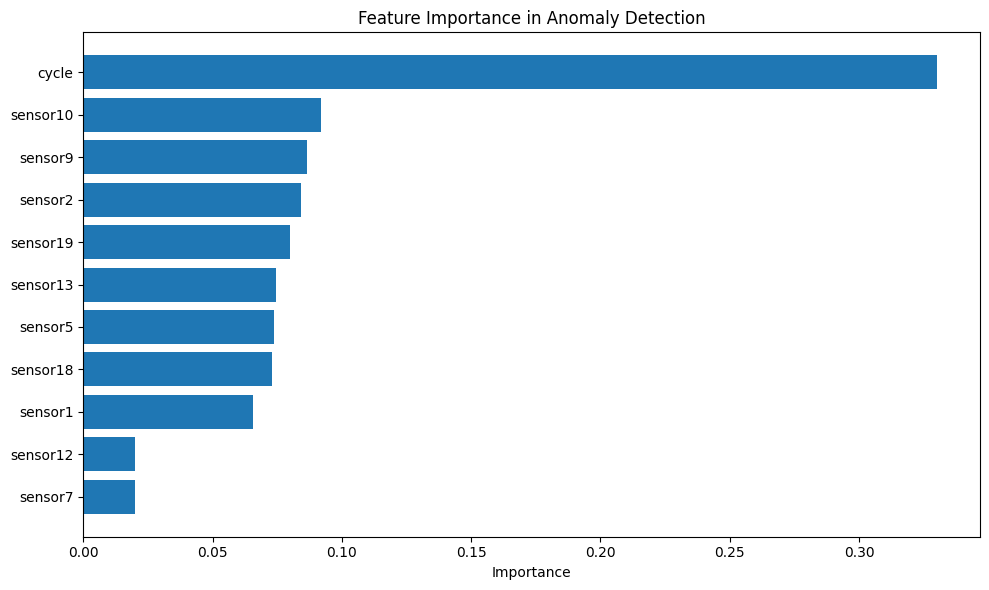

Feature importance for anomalies:
cycle: 0.3303
sensor10: 0.0921
sensor9: 0.0866
sensor2: 0.0841
sensor19: 0.0799
sensor13: 0.0745
sensor5: 0.0739
sensor18: 0.0732
sensor1: 0.0657
sensor12: 0.0199
sensor7: 0.0198


In [18]:
def analyze_feature_importance(model, X, anomaly_indices, selected_features):
    """
    Analyze which features contribute most to anomalies.
    
    Args:
        model: Trained model
        X: Input sequences
        anomaly_indices: Indices of anomalous sequences
        selected_features: Names of selected features
        
    Returns:
        importance_dict: Dictionary of feature importance
    """
    # Select anomalous sequences
    anomalous_sequences = X[anomaly_indices]
    
    # Get reconstructions
    reconstructions = model.predict(anomalous_sequences)
    
    # Calculate error for each feature
    feature_errors = np.mean(np.square(anomalous_sequences - reconstructions), axis=(0, 1))
    
    # Map errors to feature names
    importance_dict = {selected_features[i]: float(feature_errors[i]) 
                      for i in range(len(selected_features))}
    
    # Normalize to get relative importance
    total_importance = sum(importance_dict.values())
    for feature in importance_dict:
        importance_dict[feature] /= total_importance
    
    # Sort by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_importance

# Find which features contribute most to anomalies
if sum(adaptive_anomalies) > 0:
    feature_importance = analyze_feature_importance(
        model_lstm, 
        X_test, 
        adaptive_anomalies, 
        selected_features
    )
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features = [x[0] for x in feature_importance]
    importance = [x[1] for x in feature_importance]
    
    plt.barh(features, importance)
    plt.xlabel('Importance')
    plt.title('Feature Importance in Anomaly Detection')
    plt.gca().invert_yaxis()  # Higher importance at the top
    plt.tight_layout()
    plt.show()
    
    print("Feature importance for anomalies:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")
else:
    print("No anomalies detected for feature importance analysis")


Adaptive Threshold: 0.424294
Adaptive Threshold (mean + 3*std): 0.439882


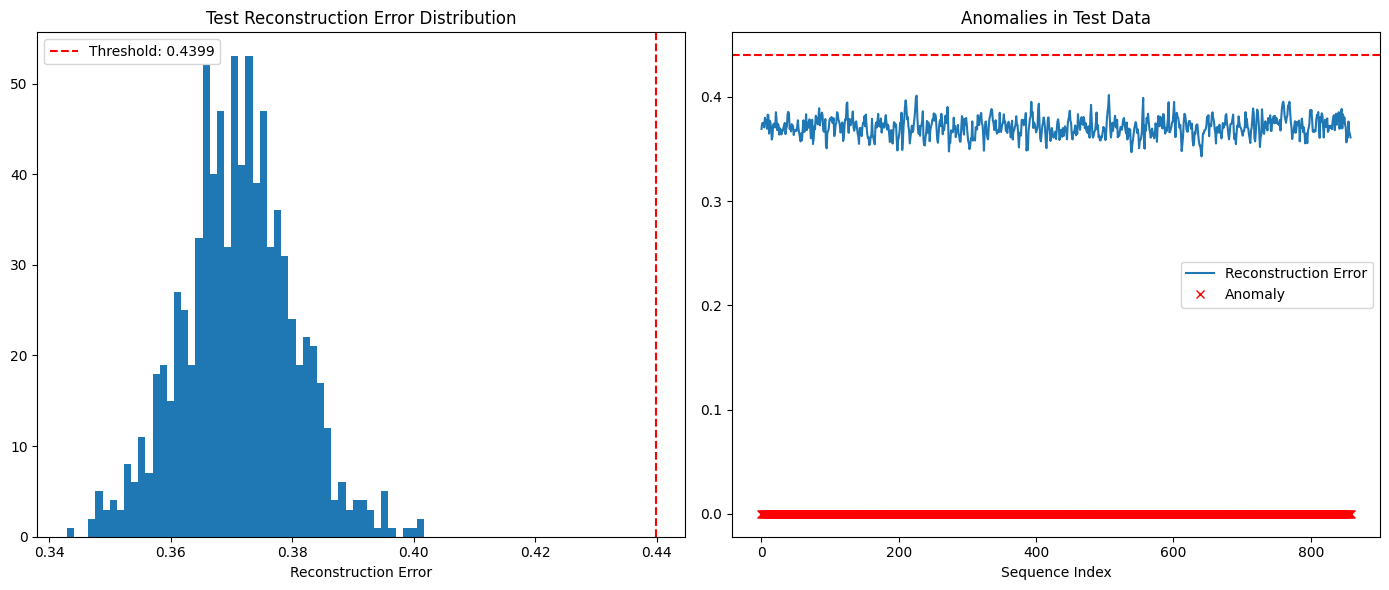

In [19]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os

# Path to the Anomaly Transformer repo
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32

train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load the Anomaly Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],  # sequence length
    enc_in=X_train.shape[2],    # number of features
    c_out=X_train.shape[2],     # same as input
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)

# Load pretrained weights if you have them (optional)
# model.load_state_dict(torch.load("/kaggle/input/...", map_location=device))

# Inference mode
model.eval()

def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # model returns tuple (output, series_assoc, prior_assoc)
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sequence
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute reconstruction errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# Calculate threshold using 95th percentile from train errors
threshold = np.percentile(train_errors, 95)
print(f"Adaptive Threshold: {threshold:.6f}")

# Detect anomalies
mean = np.mean(train_errors)
std = np.std(train_errors)
k = 3  # Sensitivity factor; 2 is more sensitive, 3 is more conservative

threshold = mean + k * std
print(f"Adaptive Threshold (mean + {k}*std): {threshold:.6f}")


# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(test_errors, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.xlabel("Reconstruction Error")
plt.title("Test Reconstruction Error Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_errors, label="Reconstruction Error")
plt.plot(anomalies * test_errors, 'rx', label="Anomaly")
plt.axhline(threshold, color='r', linestyle='--')
plt.title("Anomalies in Test Data")
plt.xlabel("Sequence Index")
plt.legend()

plt.tight_layout()
plt.show()


KDE Adaptive Threshold (log-density): 1.287875
Number of anomalies detected: 43 / 859


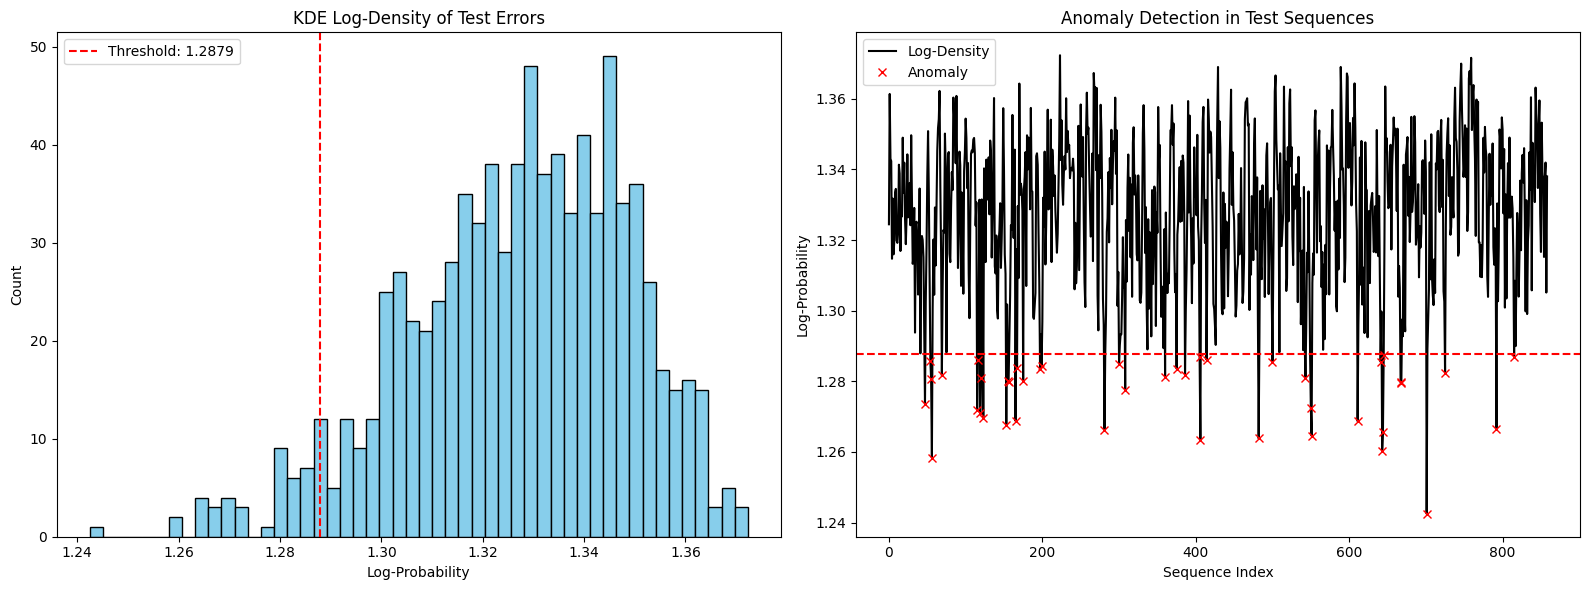

In [20]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Add Anomaly Transformer repo to path
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],
    enc_in=X_train.shape[2],
    c_out=X_train.shape[2],
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)



# Inference mode
model.eval()

# Reconstruction Error Function
def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # Output only
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sample
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# === KDE Thresholding ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(train_errors.reshape(-1, 1))
log_density = kde.score_samples(test_errors.reshape(-1, 1))
threshold = np.percentile(log_density, 5)  # Bottom 5% log-probability
anomalies = log_density < threshold

print(f"KDE Adaptive Threshold (log-density): {threshold:.6f}")
print(f"Number of anomalies detected: {np.sum(anomalies)} / {len(anomalies)}")

# === Visualization ===
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of log-probabilities
plt.subplot(1, 2, 1)
plt.hist(log_density, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("KDE Log-Density of Test Errors")
plt.xlabel("Log-Probability")
plt.ylabel("Count")
plt.legend()

# Plot 2: Sequence with anomalies
plt.subplot(1, 2, 2)
plt.plot(log_density, label='Log-Density', color='black')
plt.plot(np.where(anomalies)[0], log_density[anomalies], 'rx', label='Anomaly')
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Anomaly Detection in Test Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("Log-Probability")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 2.689194
Epoch 2/20, Loss: 0.978976
Epoch 3/20, Loss: 0.419044
Epoch 4/20, Loss: 0.260259
Epoch 5/20, Loss: 0.187331
Epoch 6/20, Loss: 0.145640
Epoch 7/20, Loss: 0.120832
Epoch 8/20, Loss: 0.105169
Epoch 9/20, Loss: 0.094671
Epoch 10/20, Loss: 0.087219
Epoch 11/20, Loss: 0.081824
Epoch 12/20, Loss: 0.077874
Epoch 13/20, Loss: 0.074530
Epoch 14/20, Loss: 0.072014
Epoch 15/20, Loss: 0.069959
Epoch 16/20, Loss: 0.068212
Epoch 17/20, Loss: 0.066746
Epoch 18/20, Loss: 0.065576
Epoch 19/20, Loss: 0.064336
Epoch 20/20, Loss: 0.063391
KDE Adaptive Threshold (log-density): 1.383636
Number of anomalies detected: 43 / 859


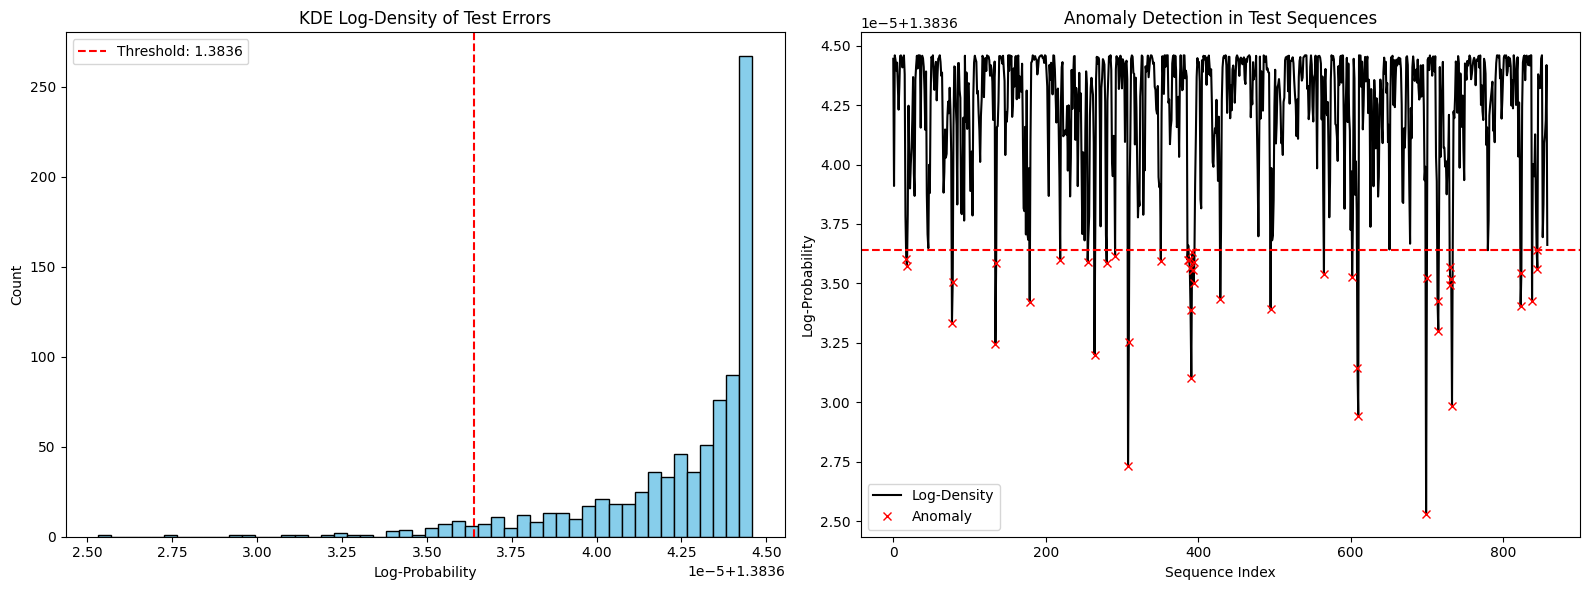

In [21]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Add Anomaly Transformer repo to path
sys.path.append("/kaggle/input/anomaly-transformer/pytorch/default/1/Anomaly-Transformer-main")

from model.AnomalyTransformer import AnomalyTransformer

# Convert NumPy arrays to PyTorch tensors
X_train_torch = torch.tensor(X_train_split, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
batch_size = 32
train_loader = data.DataLoader(X_train_torch, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(X_test_torch, batch_size=batch_size, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnomalyTransformer(
    win_size=X_train.shape[1],
    enc_in=X_train.shape[2],
    c_out=X_train.shape[2],
    e_layers=3,
    d_model=512,
    n_heads=8,
    d_ff=512,
    dropout=0.1,
    activation='gelu'
).to(device)


from torch.optim import Adam
import torch.nn.functional as F

# Define loss function (MSE for reconstruction + optional KL loss if used)
def train_anomaly_transformer(model, dataloader, epochs=10, lr=1e-4):
    optimizer = Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            output, series_list, prior_list, _ = model(batch)

            # Reconstruction loss (MSE)
            rec_loss = F.mse_loss(output, batch)

            # Association discrepancy loss (KL divergence across all heads/layers)
            series_loss = 0.0
            for series, prior in zip(series_list, prior_list):
                kl = series * torch.log((series + 1e-8) / (prior + 1e-8))
                series_loss += torch.mean(torch.sum(kl, dim=-1))

            loss = rec_loss + 0.1 * series_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


# Train the model
train_anomaly_transformer(model, train_loader, epochs=20, lr=1e-4)

# Save model if needed
torch.save(model.state_dict(), "/kaggle/working/anomaly_transformer_trained.pt")

# Inference mode
model.eval()

# Reconstruction Error Function
def compute_reconstruction_errors(model, dataloader):
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)[0]  # Output only
            loss = torch.mean((batch - output) ** 2, dim=(1, 2))  # MSE per sample
            errors.extend(loss.cpu().numpy())

    return np.array(errors)

# Compute errors
train_errors = compute_reconstruction_errors(model, train_loader)
test_errors = compute_reconstruction_errors(model, test_loader)

# === KDE Thresholding ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(train_errors.reshape(-1, 1))
log_density = kde.score_samples(test_errors.reshape(-1, 1))
threshold = np.percentile(log_density, 5)  # Bottom 5% log-probability
anomalies = log_density < threshold

print(f"KDE Adaptive Threshold (log-density): {threshold:.6f}")
print(f"Number of anomalies detected: {np.sum(anomalies)} / {len(anomalies)}")

# === Visualization ===
plt.figure(figsize=(16, 6))

# Plot 1: Histogram of log-probabilities
plt.subplot(1, 2, 1)
plt.hist(log_density, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("KDE Log-Density of Test Errors")
plt.xlabel("Log-Probability")
plt.ylabel("Count")
plt.legend()

# Plot 2: Sequence with anomalies
plt.subplot(1, 2, 2)
plt.plot(log_density, label='Log-Density', color='black')
plt.plot(np.where(anomalies)[0], log_density[anomalies], 'rx', label='Anomaly')
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Anomaly Detection in Test Sequences")
plt.xlabel("Sequence Index")
plt.ylabel("Log-Probability")
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import warnings
warnings.filterwarnings('ignore')

# TCN Block
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0.2):
    """
    Defines the residual block for the TCN
    
    Args:
        x: Input tensor
        dilation_rate: Dilation rate
        nb_filters: Number of convolutional filters
        kernel_size: Size of the convolutional kernel
        padding: Type of padding
        dropout_rate: Dropout rate
        
    Returns:
        A tuple (output tensor, skip connection tensor)
    """
    # Dilated causal convolution
    prev_x = x
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size,
               dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    # Additional dilated convolution
    x = Conv1D(filters=nb_filters, kernel_size=kernel_size,
               dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    
    # Residual connection
    if prev_x.shape[-1] != nb_filters:
        prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    
    x = Add()([prev_x, x])
    return x

def build_tcn_autoencoder(input_shape, nb_filters=64, kernel_size=3, 
                         nb_stacks=1, dilations=[1, 2, 4, 8, 16], 
                         dropout_rate=0.2, return_sequences=True):
    """
    Build a Temporal Convolutional Network Autoencoder
    
    Args:
        input_shape: Shape of input data (sequence_length, features)
        nb_filters: Number of convolutional filters
        kernel_size: Size of the convolutional kernel
        nb_stacks: Number of stacks of residual blocks
        dilations: List of dilation rates for successive layers
        dropout_rate: Dropout rate
        return_sequences: Whether to return the full sequence
        
    Returns:
        A TensorFlow Keras Model
    """
    # Input
    input_layer = Input(shape=input_shape)
    
    # TCN Encoder
    x = input_layer
    padding = 'causal'  # Causal padding to prevent leaking from the future
    
    for stack in range(nb_stacks):
        for dilation_rate in dilations:
            x = residual_block(x, dilation_rate, nb_filters, kernel_size, 
                               padding, dropout_rate)
    
    # Create a bottleneck
    bottleneck = GlobalAveragePooling1D()(x)
    encoded = Dense(32, activation='relu')(bottleneck)  # Bottleneck layer
    
    # Decoder - First reshape the bottleneck back to sequence form
    x = Dense(input_shape[0] * nb_filters)(encoded)
    x = Reshape((input_shape[0], nb_filters))(x)
    
    # TCN Decoder - Using standard Conv1D layers (no need for causal padding in decoder)
    for i in range(len(dilations)):
        x = Conv1D(filters=nb_filters, kernel_size=kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
    
    # Output layer
    output_layer = Conv1D(filters=input_shape[1], kernel_size=1, padding='same')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

# Function to train the TCN model
def train_tcn_model(X_train, X_val, sequence_length, n_features, epochs=50, batch_size=32):
    """
    Train a TCN autoencoder model
    
    Args:
        X_train: Training data
        X_val: Validation data
        sequence_length: Length of input sequences
        n_features: Number of features
        epochs: Number of training epochs
        batch_size: Batch size
        
    Returns:
        Trained model and training history
    """
    input_shape = (sequence_length, n_features)
    
    # Build model
    model = build_tcn_autoencoder(
        input_shape=input_shape,
        nb_filters=64,
        kernel_size=3,
        nb_stacks=1,
        dilations=[1, 2, 4, 8, 16],
        dropout_rate=0.2
    )
    
    # Print model summary
    model.summary()
    
    # Set callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'tcn_autoencoder.keras',
        monitor='val_loss',
        save_best_only=True
    )
    
    # Train model
    history = model.fit(
        X_train, X_train,  # Autoencoder reconstructs its input
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return model, history

# Function to detect anomalies
def detect_anomalies(model, X_data, threshold_percentile=95):
    """
    Detect anomalies using reconstruction error
    
    Args:
        model: Trained model
        X_data: Input data
        threshold_percentile: Percentile for threshold
        
    Returns:
        reconstruction_errors: Errors for each sequence
        threshold: Threshold value
        anomalies: Boolean array of anomalies
    """
    # Get reconstructions
    reconstructions = model.predict(X_data)
    
    # Calculate reconstruction error (MSE) for each sequence
    reconstruction_errors = np.mean(np.square(X_data - reconstructions), axis=(1, 2))
    
    # Calculate threshold
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    
    # Detect anomalies
    anomalies = reconstruction_errors > threshold
    
    return reconstruction_errors, threshold, anomalies

# Function to apply adaptive thresholding
def adaptive_thresholding(errors, window_size=10):
    """
    Apply adaptive thresholding to reconstruction errors.
    
    Args:
        errors: Reconstruction errors
        window_size: Size of the sliding window
        
    Returns:
        thresholds: Threshold values for each point
        anomalies: Boolean array indicating anomalies
    """
    thresholds = []
    anomalies = []
    
    for i in range(len(errors)):
        # Get window of errors
        start = max(0, i - window_size)
        window_errors = errors[start:i+1]
        
        # Calculate adaptive threshold (mean + 2*std)
        window_threshold = window_errors.mean() + 2 * window_errors.std()
        thresholds.append(window_threshold)
        
        # Detect anomaly
        anomalies.append(errors[i] > window_threshold)
    
    return np.array(thresholds), np.array(anomalies)


In [26]:
from sklearn.neighbors import KernelDensity
import numpy as np

def kde_threshold(errors, quantile=0.01):
    """
    Use KDE to determine a threshold for anomaly detection.

    Args:
        errors (np.ndarray): Reconstruction errors (1D array).
        quantile (float): Proportion of anomalies (e.g., 0.01 for top 1%).

    Returns:
        threshold (float): Error threshold for anomaly detection.
    """
    errors = errors.reshape(-1, 1)

    # Fit KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(errors)

    # Evaluate PDF on sorted errors
    log_density = kde.score_samples(errors)
    density = np.exp(log_density)

    # Find threshold based on low-density cutoff
    threshold_index = np.argsort(density)[:int(len(density) * quantile)]
    threshold = np.min(errors[threshold_index])
    return threshold


In [29]:
def visualize_results(X_train_split, X_val, model, X_test, test_unit_indices, selected_features):
    """
    Visualize anomaly detection results
    
    Args:
        X_train_split: Training data
        X_val: Validation data
        model: Trained model
        X_test: Test data
        test_unit_indices: Unit indices for test data
        selected_features: Selected features
        
    Returns:
        None
    """
    # Get reconstructions
    train_reconstructions = model.predict(X_train_split)
    train_errors = np.mean(np.square(X_train_split - train_reconstructions), axis=(1, 2))
    threshold = kde_threshold(train_errors, quantile=0.01)
    
    # Get test reconstructions and errors
    test_reconstructions = model.predict(X_test)
    test_errors = np.mean(np.square(X_test - test_reconstructions), axis=(1, 2))
    anomalies = test_errors > threshold
    
    # Calculate adaptive thresholds
    adaptive_thresholds, adaptive_anomalies = adaptive_thresholding(test_errors, window_size=50)
    
    # Plot training history
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('TCN Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Error distribution
    plt.subplot(2, 2, 2)
    plt.hist(test_errors, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    
    # Plot 3: Static threshold anomalies
    plt.subplot(2, 2, 3)
    plt.scatter(range(len(test_errors)), test_errors, 
               c=anomalies, cmap='coolwarm', alpha=0.7)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.6f}')
    plt.xlabel('Sequence Index')
    plt.ylabel('Reconstruction Error')
    plt.title('Static Threshold Anomalies')
    plt.colorbar(label='Is Anomaly')
    plt.legend()
    
    # Plot 4: Adaptive threshold anomalies
    plt.subplot(2, 2, 4)
    plt.plot(test_errors, label='Reconstruction Error')
    plt.plot(adaptive_thresholds, 'r--', label='Adaptive Threshold')
    plt.scatter(range(len(test_errors)), 
               test_errors * adaptive_anomalies, 
               color='red', marker='x', label='Anomalies')
    plt.xlabel('Sequence Index')
    plt.ylabel('Reconstruction Error')
    plt.title('Adaptive Thresholding Results')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Analyze feature importance if anomalies are detected
    if sum(adaptive_anomalies) > 0:
        analyze_feature_importance(model, X_test, adaptive_anomalies, selected_features)

# Function to analyze feature importance
def analyze_feature_importance(model, X, anomaly_indices, selected_features):
    """
    Analyze which features contribute most to anomalies.
    
    Args:
        model: Trained model
        X: Input sequences
        anomaly_indices: Indices of anomalous sequences
        selected_features: Names of selected features
        
    Returns:
        None
    """
    # Select anomalous sequences
    anomalous_sequences = X[anomaly_indices]
    
    # Get reconstructions
    reconstructions = model.predict(anomalous_sequences)
    
    # Calculate error for each feature
    feature_errors = np.mean(np.square(anomalous_sequences - reconstructions), axis=(0, 1))
    
    # Map errors to feature names
    importance_dict = {selected_features[i]: float(feature_errors[i]) 
                      for i in range(len(selected_features))}
    
    # Normalize to get relative importance
    total_importance = sum(importance_dict.values())
    for feature in importance_dict:
        importance_dict[feature] /= total_importance
    
    # Sort by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features = [x[0] for x in sorted_importance]
    importance = [x[1] for x in sorted_importance]
    
    plt.barh(features, importance)
    plt.xlabel('Importance')
    plt.title('Feature Importance in Anomaly Detection')
    plt.gca().invert_yaxis()  # Higher importance at the top
    plt.tight_layout()
    plt.show()
    
    print("Feature importance for anomalies:")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")

# Function to compare TCN and LSTM models
def compare_models(X_train_split, X_val, X_test, tcn_model, lstm_model):
    """
    Compare TCN and LSTM models
    
    Args:
        X_train_split: Training data
        X_val: Validation data
        X_test: Test data
        tcn_model: Trained TCN model
        lstm_model: Trained LSTM model
        
    Returns:
        None
    """
    # TCN predictions
    tcn_train_reconstructions = tcn_model.predict(X_train_split)
    tcn_train_errors = np.mean(np.square(X_train_split - tcn_train_reconstructions), axis=(1, 2))
    tcn_threshold =kde_threshold(tcn_train_errors, quantile=0.01)

    
    tcn_test_reconstructions = tcn_model.predict(X_test)
    tcn_test_errors = np.mean(np.square(X_test - tcn_test_reconstructions), axis=(1, 2))
    tcn_anomalies = tcn_test_errors > tcn_threshold
    
    # LSTM predictions
    lstm_train_reconstructions = lstm_model.predict(X_train_split)
    lstm_train_errors = np.mean(np.square(X_train_split - lstm_train_reconstructions), axis=(1, 2))
    lstm_threshold = kde_threshold(lstm_train_errors, quantile=0.01)

    
    lstm_test_reconstructions = lstm_model.predict(X_test)
    lstm_test_errors = np.mean(np.square(X_test - lstm_test_reconstructions), axis=(1, 2))
    lstm_anomalies = lstm_test_errors > lstm_threshold
    
    # Calculate metrics
    tcn_anomaly_count = sum(tcn_anomalies)
    lstm_anomaly_count = sum(lstm_anomalies)
    
    # Agreement between models
    agreement = sum(tcn_anomalies & lstm_anomalies) / sum(tcn_anomalies | lstm_anomalies) if sum(tcn_anomalies | lstm_anomalies) > 0 else 0
    
    print(f"TCN detected {tcn_anomaly_count} anomalies")
    print(f"LSTM detected {lstm_anomaly_count} anomalies")
    print(f"Agreement between models: {agreement:.2%}")
    
    # Visualization
    plt.figure(figsize=(12, 10))
    
    # Plot 1: TCN vs LSTM errors
    plt.subplot(2, 1, 1)
    plt.plot(tcn_test_errors, label='TCN Errors', alpha=0.7)
    plt.plot(lstm_test_errors, label='LSTM Errors', alpha=0.7)
    plt.axhline(y=tcn_threshold, color='r', linestyle='--', label=f'TCN Threshold')
    plt.axhline(y=lstm_threshold, color='g', linestyle='--', label=f'LSTM Threshold')
    plt.xlabel('Sequence Index')
    plt.ylabel('Reconstruction Error')
    plt.title('TCN vs LSTM Reconstruction Errors')
    plt.legend()
    
    # Plot 2: Anomaly comparison
    plt.subplot(2, 1, 2)
    
    # Create a category for each combination
    both_detected = tcn_anomalies & lstm_anomalies
    tcn_only = tcn_anomalies & ~lstm_anomalies
    lstm_only = ~tcn_anomalies & lstm_anomalies
    no_anomaly = ~tcn_anomalies & ~lstm_anomalies
    
    # Plot categories
    plt.scatter(range(len(tcn_test_errors)), tcn_test_errors, 
                c=no_anomaly*0 + tcn_only*1 + lstm_only*2 + both_detected*3, 
                cmap='viridis', alpha=0.7)
    
    cbar = plt.colorbar(ticks=[0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(['No Anomaly', 'TCN Only', 'LSTM Only', 'Both Models'])
    
    plt.xlabel('Sequence Index')
    plt.ylabel('Reconstruction Error')
    plt.title('Anomaly Detection Comparison: TCN vs LSTM')
    
    plt.tight_layout()
    plt.show()


Training TCN model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 50, 11)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 50, 64)         │          2,176 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 50, 64)         │            256 │ conv1d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 50, 64)         │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 50, 64)         │              0 │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 50, 64)         │         12,352 │ dropout_49[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 50, 64)         │            256 │ conv1d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 50, 64)         │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 50, 64)         │            768 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_50 (Dropout)      │ (None, 50, 64)         │              0 │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 50, 64)         │              0 │ conv1d_53[0][0],       │
│                           │                        │                │ dropout_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_54 (Conv1D)        │ (None, 50, 64)         │         12,352 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 50, 64)         │            256 │ conv1d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 50, 64)         │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, 50, 64)         │              0 │ activation_47[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_55 (Conv1D)   

 Total params: 288,107 (1.10 MB)

 Trainable params: 286,187 (1.09 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - loss: 0.7476 - val_loss: 0.1256
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1136 - val_loss: 0.0411
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0541 - val_loss: 0.0233
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403 - val_loss: 0.0236
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0363 - val_loss: 0.0241
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0338 - val_loss: 0.0243
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0311 - val_loss: 0.0232
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - val_loss: 0.0234
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0300 - val_loss: 0.0227
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0296 - val_loss: 0.0227
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 - val_loss: 0.0230
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293 

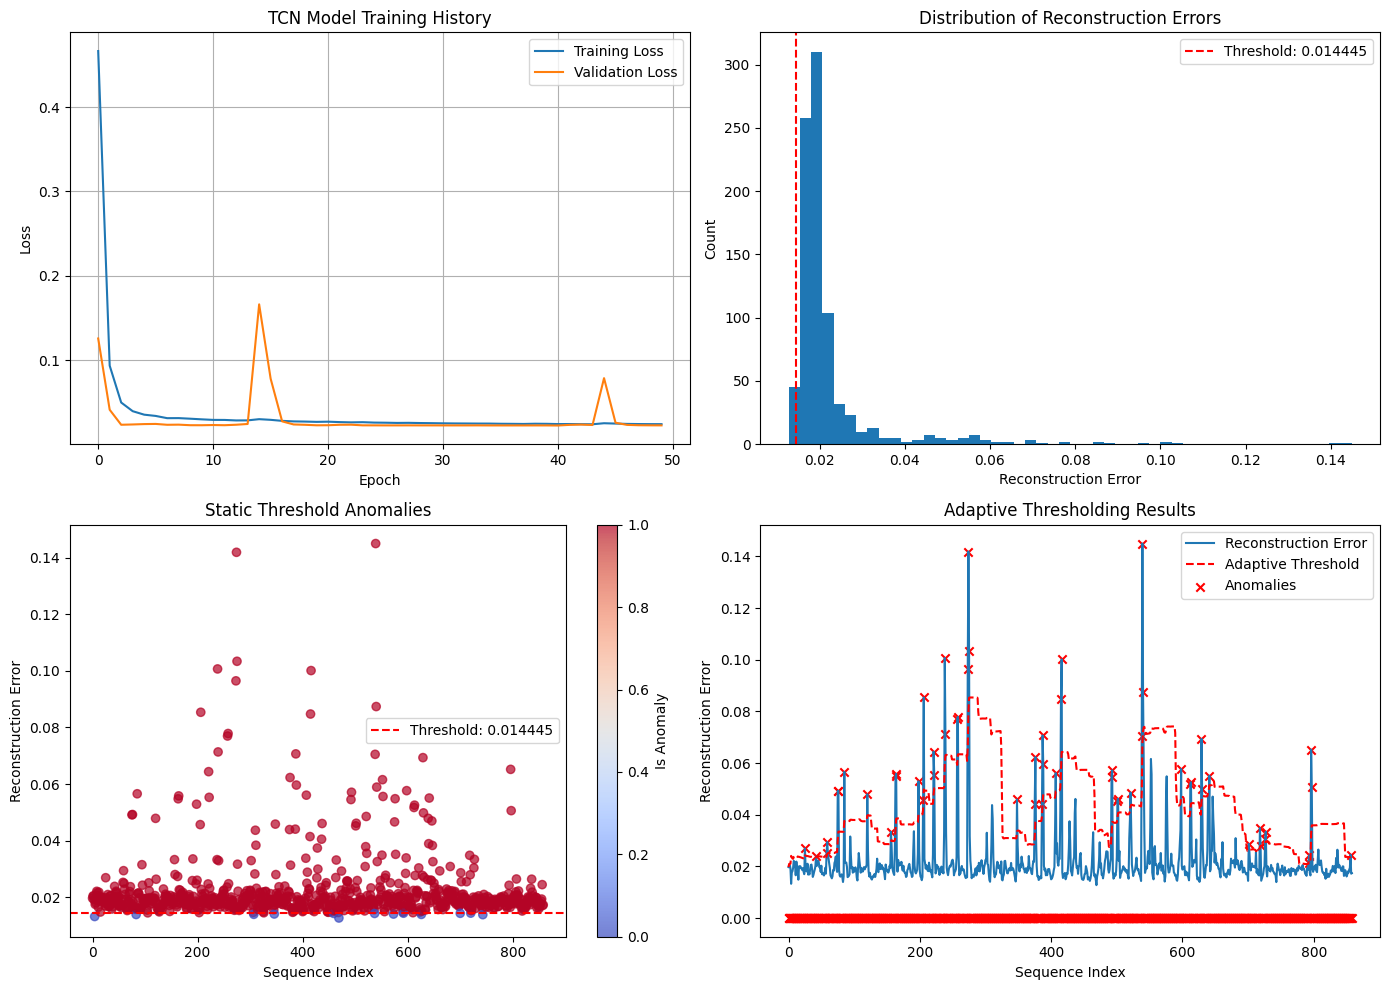

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 


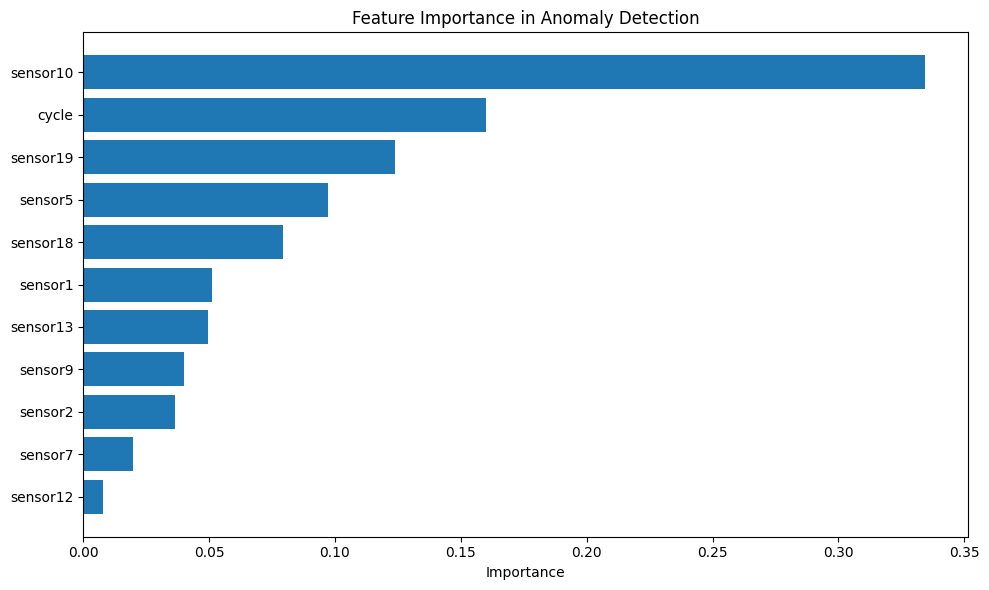

Feature importance for anomalies:
sensor10: 0.3346
cycle: 0.1602
sensor19: 0.1238
sensor5: 0.0973
sensor18: 0.0794
sensor1: 0.0510
sensor13: 0.0494
sensor9: 0.0400
sensor2: 0.0366
sensor7: 0.0199
sensor12: 0.0078
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
TCN detected 846 anomalies
LSTM detected 0 anomalies
Agreement between models: 0.00%


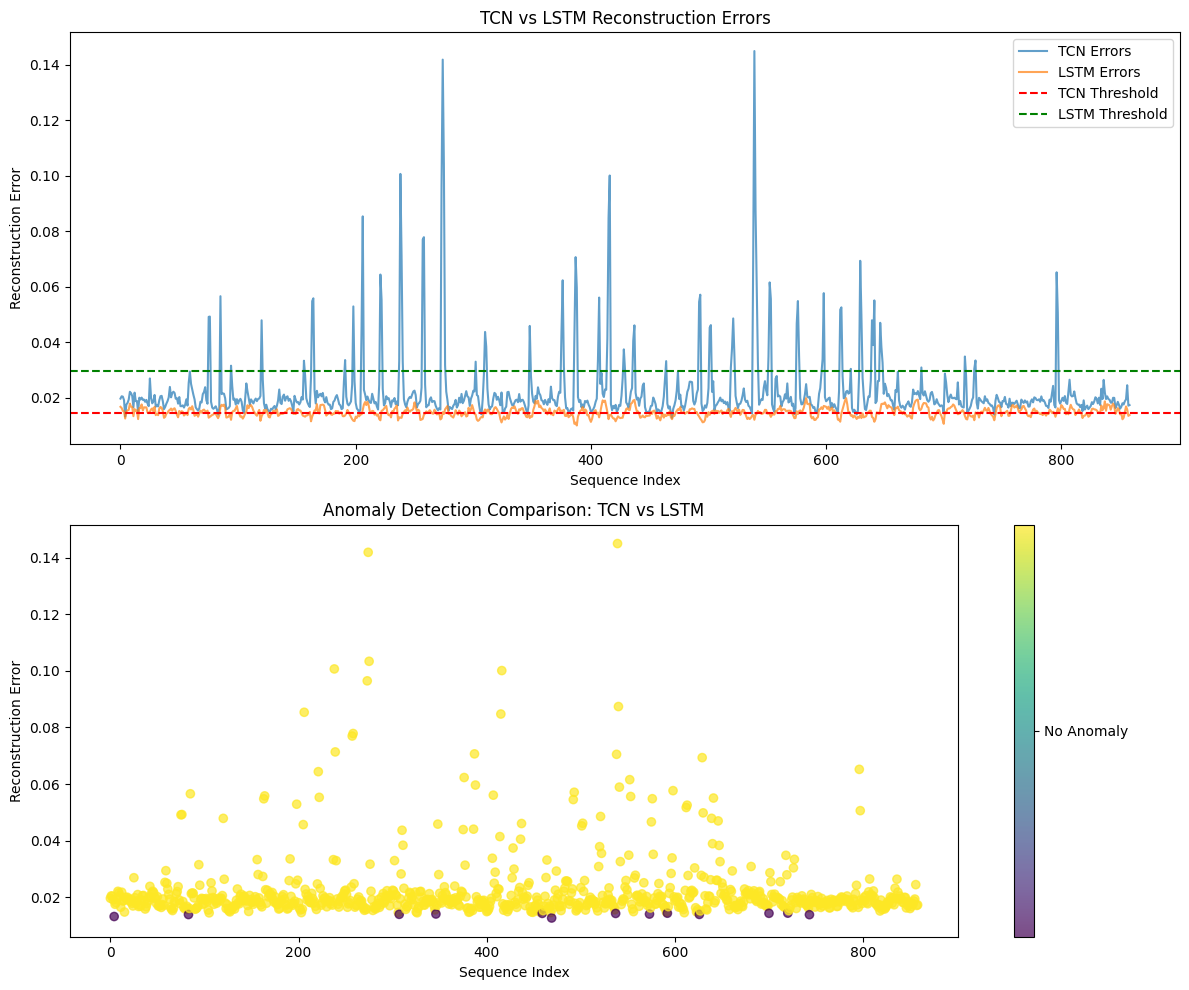

In [30]:
# Train the TCN model
print("Training TCN model...")
tcn_model, history = train_tcn_model(
    X_train_split, 
    X_val, 
    sequence_length=X_train_split.shape[1], 
    n_features=X_train_split.shape[2],
    epochs=50,
    batch_size=32
)

# Visualize TCN results
visualize_results(
    X_train_split, 
    X_val, 
    tcn_model, 
    X_test, 
    test_unit_indices, 
    selected_features
)

# Compare TCN with LSTM (assuming your existing LSTM model is named 'model')
compare_models(
    X_train_split, 
    X_val, 
    X_test, 
    tcn_model, 
    model_lstm  # Your existing LSTM model
)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.neighbors import KernelDensity

# EWMA Thresholding Implementation
def ewma_thresholding(errors, alpha=0.1, k=3.0):
    """
    Apply Exponentially Weighted Moving Average (EWMA) thresholding to reconstruction errors.
    
    Args:
        errors: Array of reconstruction errors
        alpha: Smoothing factor (0 < alpha < 1)
        k: Number of standard deviations for threshold
    
    Returns:
        thresholds: Array of threshold values for each point
        ewma_values: Array of EWMA values
        anomalies: Boolean array indicating anomalies
    """
    n = len(errors)
    ewma_values = np.zeros(n)
    ewma_std = np.zeros(n)
    thresholds = np.zeros(n)
    anomalies = np.zeros(n, dtype=bool)
    
    # Initialize with first value
    ewma_values[0] = errors[0]
    ewma_std[0] = 0  # Not enough data for std yet
    thresholds[0] = np.inf  # First point is never an anomaly
    
    # Calculate EWMA and thresholds
    for i in range(1, n):
        # Update EWMA value
        ewma_values[i] = alpha * errors[i] + (1 - alpha) * ewma_values[i-1]
        
        # Update EWMA standard deviation
        if i > 10:  # Need some history to calculate meaningful std
            # Use weighted standard deviation of recent errors
            dev = errors[max(0, i-30):i] - ewma_values[max(0, i-30):i]
            weights = (1-alpha)**np.arange(len(dev))[::-1]
            weights /= weights.sum()
            ewma_std[i] = np.sqrt(np.average(dev**2, weights=weights))
        else:
            # For early points, use simple standard deviation
            ewma_std[i] = np.std(errors[:i+1])
        
        # Set threshold and detect anomaly
        thresholds[i] = ewma_values[i] + k * ewma_std[i]
        anomalies[i] = errors[i] > thresholds[i]
    
    return thresholds, ewma_values, anomalies

# MAD Thresholding Implementation
def mad_thresholding(errors, k=3.0, window_size=None):
    """
    Apply Median Absolute Deviation (MAD) thresholding to reconstruction errors.
    
    Args:
        errors: Array of reconstruction errors
        k: Scaling factor for MAD (typically 2-3)
        window_size: Optional sliding window size (None for global)
    
    Returns:
        thresholds: Array of threshold values for each point
        anomalies: Boolean array indicating anomalies
    """
    n = len(errors)
    thresholds = np.zeros(n)
    anomalies = np.zeros(n, dtype=bool)
    
    if window_size is None:
        # Global MAD calculation
        median = np.median(errors)
        mad = np.median(np.abs(errors - median))
        
        # MAD to standard deviation conversion factor (1.4826)
        # for consistency with Gaussian distribution
        threshold = median + k * 1.4826 * mad
        
        thresholds[:] = threshold
        anomalies = errors > threshold
    else:
        # Sliding window MAD
        for i in range(n):
            # Get window of errors
            start = max(0, i - window_size)
            window_errors = errors[start:i+1]
            
            # Calculate MAD for window
            median = np.median(window_errors)
            mad = np.median(np.abs(window_errors - median))
            
            # Set threshold and detect anomaly
            thresholds[i] = median + k * 1.4826 * mad
            anomalies[i] = errors[i] > thresholds[i]
    
    return thresholds, anomalies

# KDE Thresholding Implementation
def kde_thresholding(errors, bandwidth=0.1, threshold_quantile=0.95):
    """
    Apply Kernel Density Estimation (KDE) thresholding to reconstruction errors.
    
    Args:
        errors: Array of reconstruction errors
        bandwidth: Bandwidth parameter for KDE
        threshold_quantile: Quantile for threshold (e.g., 0.95 for 95%)
    
    Returns:
        threshold: Threshold value
        densities: Density values for each point
        anomalies: Boolean array indicating anomalies
    """
    # Reshape for scikit-learn
    errors_reshaped = errors.reshape(-1, 1)
    
    # Fit KDE model
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(errors_reshaped)
    
    # Sample points for density estimation
    x_grid = np.linspace(min(errors) - 0.1, max(errors) + 0.1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(x_grid)
    densities = np.exp(log_dens)
    
    # Calculate cumulative density
    cumulative = np.cumsum(densities) / np.sum(densities)
    
    # Find threshold at specified quantile
    threshold_idx = np.searchsorted(cumulative, threshold_quantile)
    threshold = x_grid[threshold_idx][0]
    
    # Calculate densities for actual errors
    log_dens_errors = kde.score_samples(errors_reshaped)
    densities_errors = np.exp(log_dens_errors)
    
    # Detect anomalies
    anomalies = errors > threshold
    
    return threshold, densities_errors, anomalies

# Combined threshold comparison function
def compare_thresholding_methods(X_train, X_test, model, ewma_params=None, mad_params=None, kde_params=None):
    """
    Compare different thresholding methods for anomaly detection.
    
    Args:
        X_train: Training data
        X_test: Test data
        model: Trained autoencoder model
        ewma_params: Parameters for EWMA (dict)
        mad_params: Parameters for MAD (dict)
        kde_params: Parameters for KDE (dict)
    
    Returns:
        results: Dictionary with results for each method
    """
    # Default parameters
    if ewma_params is None:
        ewma_params = {'alpha': 0.1, 'k': 3.0}
    if mad_params is None:
        mad_params = {'k': 3.0, 'window_size': None}
    if kde_params is None:
        kde_params = {'bandwidth': 0.1, 'threshold_quantile': 0.95}
    
    # Get reconstructions
    train_reconstructions = model.predict(X_train)
    test_reconstructions = model.predict(X_test)
    
    # Calculate reconstruction errors
    train_errors = np.mean(np.square(X_train - train_reconstructions), axis=(1, 2))
    test_errors = np.mean(np.square(X_test - test_reconstructions), axis=(1, 2))
    
    # Apply traditional percentile thresholding (baseline)
    percentile_threshold = np.percentile(train_errors, 95)
    percentile_anomalies = test_errors > percentile_threshold
    
    # Apply EWMA thresholding
    ewma_thresholds, ewma_values, ewma_anomalies = ewma_thresholding(
        test_errors, 
        alpha=ewma_params['alpha'], 
        k=ewma_params['k']
    )
    
    # Apply MAD thresholding
    mad_thresholds, mad_anomalies = mad_thresholding(
        test_errors, 
        k=mad_params['k'], 
        window_size=mad_params['window_size']
    )
    
    # Apply KDE thresholding
    kde_threshold, kde_densities, kde_anomalies = kde_thresholding(
        train_errors,  # Use training errors to fit KDE
        bandwidth=kde_params['bandwidth'], 
        threshold_quantile=kde_params['threshold_quantile']
    )
    kde_test_anomalies = test_errors > kde_threshold
    
    # Collect results
    results = {
        'test_errors': test_errors,
        'percentile': {
            'threshold': percentile_threshold,
            'anomalies': percentile_anomalies,
            'count': sum(percentile_anomalies)
        },
        'ewma': {
            'thresholds': ewma_thresholds,
            'values': ewma_values,
            'anomalies': ewma_anomalies,
            'count': sum(ewma_anomalies)
        },
        'mad': {
            'thresholds': mad_thresholds,
            'anomalies': mad_anomalies,
            'count': sum(mad_anomalies)
        },
        'kde': {
            'threshold': kde_threshold,
            'densities': kde_densities,
            'anomalies': kde_test_anomalies,
            'count': sum(kde_test_anomalies)
        }
    }
    
    # Print summary
    print(f"Percentile (95%) detected {results['percentile']['count']} anomalies")
    print(f"EWMA detected {results['ewma']['count']} anomalies")
    print(f"MAD detected {results['mad']['count']} anomalies")
    print(f"KDE detected {results['kde']['count']} anomalies")
    
    return results


In [24]:
# Function to visualize thresholding methods comparison
def visualize_thresholding_comparison(results):
    """
    Visualize comparison of different thresholding methods.
    
    Args:
        results: Results dictionary from compare_thresholding_methods
    
    Returns:
        None
    """
    test_errors = results['test_errors']
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    
    # Plot 1: EWMA
    axes[0].plot(test_errors, label='Reconstruction Error', alpha=0.7)
    axes[0].plot(results['ewma']['thresholds'], 'r--', label='EWMA Threshold')
    axes[0].plot(results['ewma']['values'], 'g-', label='EWMA Value', alpha=0.5)
    axes[0].scatter(
        np.where(results['ewma']['anomalies'])[0], 
        test_errors[results['ewma']['anomalies']], 
        color='red', 
        marker='x', 
        label='Anomalies'
    )
    axes[0].set_xlabel('Sequence Index')
    axes[0].set_ylabel('Reconstruction Error')
    axes[0].set_title(f'EWMA Thresholding (Detected {results["ewma"]["count"]} anomalies)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: MAD
    axes[1].plot(test_errors, label='Reconstruction Error', alpha=0.7)
    axes[1].plot(results['mad']['thresholds'], 'r--', label='MAD Threshold')
    axes[1].scatter(
        np.where(results['mad']['anomalies'])[0], 
        test_errors[results['mad']['anomalies']], 
        color='red', 
        marker='x', 
        label='Anomalies'
    )
    axes[1].set_xlabel('Sequence Index')
    axes[1].set_ylabel('Reconstruction Error')
    axes[1].set_title(f'MAD Thresholding (Detected {results["mad"]["count"]} anomalies)')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot 3: KDE
    axes[2].plot(test_errors, label='Reconstruction Error', alpha=0.7)
    axes[2].axhline(results['kde']['threshold'], color='r', linestyle='--', label='KDE Threshold')
    axes[2].scatter(
        np.where(results['kde']['anomalies'])[0], 
        test_errors[results['kde']['anomalies']], 
        color='red', 
        marker='x', 
        label='Anomalies'
    )
    axes[2].set_xlabel('Sequence Index')
    axes[2].set_ylabel('Reconstruction Error')
    axes[2].set_title(f'KDE Thresholding (Detected {results["kde"]["count"]} anomalies)')
    axes[2].legend()
    axes[2].grid(True)
    
    # Add a distribution plot for KDE
    fig2, ax = plt.subplots(figsize=(12, 6))
    
    # Sample points for density visualization
    x_grid = np.linspace(min(test_errors) - 0.1, max(test_errors) + 0.1, 1000)
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(test_errors.reshape(-1, 1))
    log_dens = kde.score_samples(x_grid.reshape(-1, 1))
    densities = np.exp(log_dens)
    
    # Plot density
    ax.plot(x_grid, densities, label='KDE Density')
    ax.axvline(results['kde']['threshold'], color='r', linestyle='--', 
               label=f'KDE Threshold: {results["kde"]["threshold"]:.6f}')
    ax.hist(test_errors, bins=50, density=True, alpha=0.5, label='Error Distribution')
    ax.set_xlabel('Reconstruction Error')
    ax.set_ylabel('Density')
    ax.set_title('KDE Density Estimation for Reconstruction Errors')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to display agreement between methods
def agreement_analysis(results):
    """
    Analyze the agreement between different thresholding methods.
    
    Args:
        results: Results dictionary from compare_thresholding_methods
    
    Returns:
        None
    """
    # Extract anomaly arrays
    percentile_anomalies = results['percentile']['anomalies']
    ewma_anomalies = results['ewma']['anomalies']
    mad_anomalies = results['mad']['anomalies']
    kde_anomalies = results['kde']['anomalies']
    
    # Calculate pairwise agreement
    methods = ['Percentile', 'EWMA', 'MAD', 'KDE']
    anomalies = [percentile_anomalies, ewma_anomalies, mad_anomalies, kde_anomalies]
    
    agreement_matrix = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            if i == j:
                agreement_matrix[i, j] = 1.0
            else:
                # Jaccard similarity for anomaly agreement
                intersection = np.sum(anomalies[i] & anomalies[j])
                union = np.sum(anomalies[i] | anomalies[j])
                agreement_matrix[i, j] = intersection / union if union > 0 else 0
    
    # Create a heatmap of agreement
    plt.figure(figsize=(10, 8))
    plt.imshow(agreement_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Agreement Score')
    
    # Add labels
    for i in range(4):
        for j in range(4):
            text = f"{agreement_matrix[i, j]:.2f}"
            plt.text(j, i, text, ha='center', va='center', 
                     color='white' if agreement_matrix[i, j] < 0.7 else 'black')
    
    plt.xticks(range(4), methods)
    plt.yticks(range(4), methods)
    plt.title('Agreement Between Thresholding Methods')
    plt.tight_layout()
    plt.show()
    
    # Create a Venn-like visualization to show overlapping anomalies
    plt.figure(figsize=(12, 6))
    
    # Create category for each combination of methods
    n = len(results['test_errors'])
    categories = np.zeros(n)
    
    for i, error in enumerate(results['test_errors']):
        # Create a binary code based on which methods detected this point
        code = 0
        if percentile_anomalies[i]: code += 1
        if ewma_anomalies[i]: code += 2
        if mad_anomalies[i]: code += 4
        if kde_anomalies[i]: code += 8
        categories[i] = code
    
    # Count unique combinations
    unique_categories, counts = np.unique(categories, return_counts=True)
    combinations = []
    
    for cat in unique_categories:
        if cat > 0:  # Skip non-anomalies
            methods_list = []
            if cat & 1: methods_list.append('Percentile')
            if cat & 2: methods_list.append('EWMA')
            if cat & 4: methods_list.append('MAD')
            if cat & 8: methods_list.append('KDE')
            methods_str = ' & '.join(methods_list)
            combinations.append((methods_str, int(cat), sum(categories == cat)))
    
    # Sort by count
    combinations.sort(key=lambda x: x[2], reverse=True)
    
    # Plot the results
    plt.bar(range(len(combinations)), [c[2] for c in combinations])
    plt.xticks(range(len(combinations)), [c[0] for c in combinations], rotation=90)
    plt.xlabel('Method Combination')
    plt.ylabel('Count of Anomalies')
    plt.title('Overlap in Anomaly Detection Between Methods')
    plt.tight_layout()
    plt.show()
    
    # Print a summary of the unique anomalies for each method
    print("\nUnique Anomalies Detected by Each Method:")
    
    # Percentile unique
    unique_percentile = sum(percentile_anomalies & ~ewma_anomalies & ~mad_anomalies & ~kde_anomalies)
    print(f"Percentile only: {unique_percentile}")
    
    # EWMA unique
    unique_ewma = sum(~percentile_anomalies & ewma_anomalies & ~mad_anomalies & ~kde_anomalies)
    print(f"EWMA only: {unique_ewma}")
    
    # MAD unique
    unique_mad = sum(~percentile_anomalies & ~ewma_anomalies & mad_anomalies & ~kde_anomalies)
    print(f"MAD only: {unique_mad}")
    
    # KDE unique
    unique_kde = sum(~percentile_anomalies & ~ewma_anomalies & ~mad_anomalies & kde_anomalies)
    print(f"KDE only: {unique_kde}")
    
    # Anomalies detected by all methods
    all_methods = sum(percentile_anomalies & ewma_anomalies & mad_anomalies & kde_anomalies)
    print(f"\nAnomalies detected by ALL methods: {all_methods}")

# Function to analyze feature contribution to anomalies by method
def feature_contribution_by_method(X_test, model, results, selected_features):
    """
    Analyze how features contribute to anomalies detected by different methods.
    
    Args:
        X_test: Test data
        model: Trained model
        results: Results dictionary from compare_thresholding_methods
        selected_features: Names of selected features
        
    Returns:
        None
    """
    # Get reconstructions
    test_reconstructions = model.predict(X_test)
    
    # Extract anomaly indices for each method
    methods = ['percentile', 'ewma', 'mad', 'kde']
    anomaly_indices = {
        method: np.where(results[method]['anomalies'])[0]
        for method in methods
    }
    
    # Create a figure for feature importance comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Calculate feature importance for each method
    for i, method in enumerate(methods):
        indices = anomaly_indices[method]
        
        if len(indices) > 0:
            # Select anomalous sequences
            anomalous_sequences = X_test[indices]
            anomalous_reconstructions = test_reconstructions[indices]
            
            # Calculate error for each feature
            feature_errors = np.mean(np.square(anomalous_sequences - anomalous_reconstructions), axis=(0, 1))
            
            # Map errors to feature names
            importance_dict = {selected_features[j]: float(feature_errors[j]) 
                              for j in range(len(selected_features))}
            
            # Normalize to get relative importance
            total_importance = sum(importance_dict.values())
            for feature in importance_dict:
                importance_dict[feature] /= total_importance
            
            # Sort by importance
            sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
            
            # Plot feature importance
            features = [x[0] for x in sorted_importance]
            importance = [x[1] for x in sorted_importance]
            
            axes[i].barh(features, importance)
            axes[i].set_xlabel('Importance')
            axes[i].set_title(f'Feature Importance - {method.upper()} ({len(indices)} anomalies)')
            axes[i].invert_yaxis()  # Higher importance at the top
            
            # Print top features
            print(f"\nTop features for {method.upper()} anomalies:")
            for feature, imp in sorted_importance[:5]:
                print(f"{feature}: {imp:.4f}")
        else:
            axes[i].text(0.5, 0.5, f"No anomalies detected by {method.upper()}", 
                         ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [25]:
ewma_params = {'alpha': 0.1, 'k': 3.0}
mad_params = {'k': 3.0, 'window_size': None}  # None for global MAD
kde_params = {'bandwidth': 0.1, 'threshold_quantile': 0.95}

# Compare thresholding methods
# Use your trained model (either LSTM or TCN)
results = compare_thresholding_methods(
    X_train_split,  # Your training data
    X_test,         # Your test data
    model,          # Your trained model
    ewma_params=ewma_params,
    mad_params=mad_params,
    kde_params=kde_params
)

# Visualize the comparison
visualize_thresholding_comparison(results)

# Analyze agreement between methods
agreement_analysis(results)

# Analyze feature contribution by method
feature_contribution_by_method(
    X_test,
    model,
    results,
    selected_features  # Your selected features from the original code
)

AttributeError: 'AnomalyTransformer' object has no attribute 'predict'

In [1]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the generator model (G)
# def build_generator(latent_dim, sequence_length, n_features):
#     model = models.Sequential()
#     model.add(layers.Dense(128, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(sequence_length * n_features, activation='tanh'))
#     model.add(layers.Reshape((sequence_length, n_features)))
#     return model

# # Define the discriminator model (D)
# def build_discriminator(sequence_length, n_features):
#     model = models.Sequential()
#     model.add(layers.Flatten(input_shape=(sequence_length, n_features)))
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dense(128))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     return model

# # Define the GAN model (combines generator and discriminator)
# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     model = models.Sequential()
#     model.add(generator)
#     model.add(discriminator)
#     return model

# # Compile and train the MAD-GAN model
# def compile_and_train_gan(X_train, sequence_length, n_features, latent_dim, epochs=10000, batch_size=64):
#     # Build and compile the discriminator
#     discriminator = build_discriminator(sequence_length, n_features)
#     discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    
#     # Build and compile the generator
#     generator = build_generator(latent_dim, sequence_length, n_features)
    
#     # Build the GAN
#     gan = build_gan(generator, discriminator)
#     gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    
#     # Training loop
#     half_batch = batch_size // 2
#     for epoch in range(epochs):
#         # Select a random half-batch of real data
#         idx = np.random.randint(0, X_train.shape[0], half_batch)
#         real_data = X_train[idx]
        
#         # Generate a half-batch of fake data
#         noise = np.random.normal(0, 1, (half_batch, latent_dim))
#         fake_data = generator.predict(noise)
        
#         # Train the discriminator (real vs fake)
#         d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
#         d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
#         # Train the generator (wants discriminator to think it's real)
#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
#         # Print progress
#         if epoch % 1000 == 0:
#             print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

#     return generator, discriminator

# # Anomaly detection using MAD-GAN
# from sklearn.neighbors import KernelDensity
# import numpy as np
# import matplotlib.pyplot as plt

# def detect_anomalies_with_kde(generator, discriminator, X_test, sequence_length, bandwidth=0.1, threshold_factor=2.0):
#     # Get the discriminator's predictions on the test data
#     preds = discriminator.predict(X_test, batch_size=64, verbose=0)

    
#     # Anomaly scores are based on discriminator's confidence (lower = more anomalous)
#     anomaly_scores = 1 - preds.flatten()  # Convert to higher score = more anomalous
    
#     # Fit a KDE to the anomaly scores
#     kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
#     kde.fit(anomaly_scores.reshape(-1, 1))  # Reshape to 2D as required by KernelDensity
    
#     # Calculate the log likelihood for each sample in the anomaly scores
#     log_likelihood = kde.score_samples(anomaly_scores.reshape(-1, 1))
    
#     # Convert log likelihood to anomaly score (lower log likelihood = more anomalous)
#     kde_anomaly_scores = -log_likelihood  # We negate because lower log likelihood means higher anomaly
    
#     # Calculate threshold for anomaly detection based on KDE scores
#     threshold = np.percentile(kde_anomaly_scores, threshold_factor * 100)
    
#     # Identify anomalies based on the threshold
#     anomalies = kde_anomaly_scores > threshold
    
#     # Plot anomaly scores
#     plt.figure(figsize=(10, 6))
#     plt.plot(kde_anomaly_scores, label='Anomaly Scores (KDE)')
#     plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
#     plt.xlabel('Test Samples')
#     plt.ylabel('Anomaly Score (KDE)')
#     plt.title('Anomaly Detection using MAD-GAN with KDE')
#     plt.legend()
#     plt.show()
    
#     return anomalies, kde_anomaly_scores



# # Example usage:
# latent_dim = 100  # Latent space dimensionality
# sequence_length = 50  # Sequence length for input data
# n_features = len(selected_features)  # Number of features in the dataset

# # Compile and train the MAD-GAN
# generator, discriminator = compile_and_train_gan(X_train_split, sequence_length, n_features, latent_dim)

# # Detect anomalies in the test data
# anomalies, anomaly_scores = detect_anomalies(generator, discriminator, X_test, sequence_length, threshold=0.5)

# # Print results
# print(f"Detected anomalies: {sum(anomalies)} out of {len(anomalies)} samples.")


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.neighbors import KernelDensity

# Generator
def build_generator(latent_dim, sequence_length, n_features):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(sequence_length * n_features, activation='tanh'))
    model.add(layers.Reshape((sequence_length, n_features)))
    return model

# Discriminator
def build_discriminator(sequence_length, n_features):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(sequence_length, n_features)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile and train GAN
def compile_and_train_gan(X_train, sequence_length, n_features, latent_dim, epochs=10000, batch_size=64):
    discriminator = build_discriminator(sequence_length, n_features)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    generator = build_generator(latent_dim, sequence_length, n_features)

    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = batch_size // 2

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_data = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 200 == 0:
            g_loss_value = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss
            print(f"{epoch} [D loss: {d_loss[0]:.4f} | Acc: {100 * d_loss[1]:.2f}%] [G loss: {g_loss_value:.4f}]")
            tf.keras.backend.clear_session()
            gc.collect()

    return generator, discriminator

# KDE-based anomaly detection
def detect_anomalies_with_kde(generator, discriminator, X_test, bandwidth=0.1, threshold_factor=2.0):
    preds = discriminator.predict(X_test, batch_size=64, verbose=0)
    anomaly_scores = 1 - preds.flatten()

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(anomaly_scores.reshape(-1, 1))
    log_likelihood = kde.score_samples(anomaly_scores.reshape(-1, 1))
    kde_anomaly_scores = -log_likelihood

    threshold = np.percentile(kde_anomaly_scores, threshold_factor * 100)
    anomalies = kde_anomaly_scores > threshold

    plt.figure(figsize=(10, 6))
    plt.plot(kde_anomaly_scores, label='Anomaly Scores (KDE)')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Test Samples')
    plt.ylabel('Anomaly Score (KDE)')
    plt.title('Anomaly Detection using MAD-GAN with KDE')
    plt.legend()
    plt.show()

    return anomalies, kde_anomaly_scores


In [ ]:
latent_dim = 100
sequence_length = 50
n_features = len(selected_features)

generator, discriminator = compile_and_train_gan(
    X_train_split, sequence_length, n_features, latent_dim
)

anomalies, anomaly_scores = detect_anomalies_with_kde( 
    generator, discriminator, X_test, sequence_length
)

print(f"Detected anomalies: {np.sum(anomalies)} out of {len(anomalies)} samples.")

0 [D loss: 0.9235 | Acc: 25.00%] [G loss: 0.8096]
200 [D loss: 1.8237 | Acc: 3.15%] [G loss: 1.8261]
400 [D loss: 2.2593 | Acc: 1.58%] [G loss: 2.2609]
600 [D loss: 2.5110 | Acc: 1.05%] [G loss: 2.5121]
800 [D loss: 2.6847 | Acc: 0.79%] [G loss: 2.6856]
1000 [D loss: 2.8185 | Acc: 0.63%] [G loss: 2.8192]
1200 [D loss: 2.9249 | Acc: 0.53%] [G loss: 2.9255]
1400 [D loss: 3.0125 | Acc: 0.45%] [G loss: 3.0131]
1600 [D loss: 3.0861 | Acc: 0.40%] [G loss: 3.0866]
1800 [D loss: 3.1499 | Acc: 0.35%] [G loss: 3.1504]
2000 [D loss: 3.2054 | Acc: 0.32%] [G loss: 3.2058]
2200 [D loss: 3.2552 | Acc: 0.29%] [G loss: 3.2556]
2400 [D loss: 3.3002 | Acc: 0.26%] [G loss: 3.3006]
2600 [D loss: 3.3408 | Acc: 0.24%] [G loss: 3.3411]
2800 [D loss: 3.3781 | Acc: 0.23%] [G loss: 3.3784]


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(kde_anomaly_scores, label='Anomaly Scores (KDE)')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Test Samples')
plt.ylabel('Anomaly Score (KDE)')
plt.title('Anomaly Detection using MAD-GAN with KDE')
plt.legend()
plt.show()


In [ ]:
caereh